## Load Packages

In [1]:
pip install suncalc

  Preparing metadata (setup.py) ... done
  Created wheel for suncalc: filename=suncalc-0.1.2-py3-none-any.whl size=9495 sha256=ed2e9dca7b0236f7c2c7670f437209724595db74507daf9d0bcd2f3fb5bf903f
  Stored in directory: /home/daniel/.cache/pip/wheels/87/e4/ba/b0c65634cecfdb83d2e66fc8e22fb8920e4e8e12307035ec3f
Successfully built suncalc
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import urllib.request
import time
import calendar
from suncalc import get_position, get_times
from datetime import datetime, date, timedelta
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

## Scraping Sky Cam

### Get List of Dates between 2018/07/01 and 2022/11/12

In [2]:
from datetime import date, timedelta

start_date = date(2018, 7, 1) 
end_date = date(2022, 11,12 )     # perhaps date.now()

delta = end_date - start_date   # returns timedelta

date_list=[]
for i in range(delta.days + 1):
    date_list.append(start_date + timedelta(days=i))

### Convert to London Time Zone

In [3]:
def london_time(naive_time):
    tz = pytz.timezone('UTC')
    tz_time = tz.localize(naive_time)
    london_tz = pytz.timezone('Europe/London')
    london_ti = tz_time.astimezone(london_tz)
    return london_ti

### Get the Sun Position

In [4]:
sunrise_list=[]
sunset_list=[]
for k in range(len(date_list)):
    ts=get_times(datetime(date_list[k].year, date_list[k].month, date_list[k].day,12,0),lon,lat)["sunrise"]
    sunrise_list.append(london_time(datetime(ts.year,ts.month,ts.day,ts.hour,ts.minute)))
    ts=get_times(datetime(date_list[k].year, date_list[k].month, date_list[k].day,12,0),lon,lat)["sunset"]
    sunset_list.append(london_time(datetime(ts.year,ts.month,ts.day,ts.hour,ts.minute)))

/home/daniel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/suncalc/suncalc.py:202: RuntimeWarning: invalid value encountered in arccos
  return acos((sin(h) - sin(phi) * sin(d)) / (cos(phi) * cos(d)))


### Define a Function for Rounding 1,2,3,4 Minutes down to 0,5,10,15,...

In [5]:
def myround(x, base=5):
    return base * int(x/base)

### Create URL-List with Timestamps of Datetime

In [6]:
url_base="http://nw3weather.co.uk/camchive/hik"
url_list=[]
sun_position=[]
datetime_list=[]

for i,j in enumerate(sunrise_list):
    start_date = datetime(sunrise_list[i].year,sunrise_list[i].month,sunrise_list[i].day,sunrise_list[i].hour+1,myround(sunrise_list[i].minute))
    end_date = datetime(sunset_list[i].year,sunset_list[i].month,sunset_list[i].day,sunset_list[i].hour-1,myround(sunset_list[i].minute))
    delta = timedelta(minutes=5)
    
    while (start_date <= end_date):
        datetime_list.append(start_date)
        sun_position.append(get_position(start_date, lon, lat))
        y=start_date.strftime("%Y")
        mo=start_date.strftime("%m")
        d=start_date.strftime("%d")
        h=start_date.strftime("%H")
        mi=start_date.strftime("%M")
        url_list.append(f"{url_base}/{y}/{mo}/{d}/{h}{mi}hik.jpg")
        start_date += delta
    

    

### Create Dataframe

In [33]:
data=pd.DataFrame(sun_position,index=list(range(len(sun_position))))
data["datetime"]=datetime_list
data["URL"]=url_list
data["foto_filepath"]=""

### Scrape Pictures from Website with URL List

In [12]:
#start = time.time()

index_list=[]
for index,url in enumerate(url_list[187084:]):
    response = requests.get(url)            
    if response.status_code==200:
        urllib.request.urlretrieve(url, "./SkyCam/"+url[-22:].replace("/","_").replace("hik",""))
        index_list.append(index)
        print(f"{100*(187084+index+1)/len(url_list)}% heruntergeladen (Index: {index})...", end='\r')
#dur=time.time() - start

# Duration total: len(url_list)*dur/(10*60*60) -> 23 h
# Total Files Size: 1.92*len(url_list)/10 -> 38 GB

### Get number and filepath of downloaded images

In [15]:
from os import listdir
from os.path import isfile, join
mypath="./SkyCam"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

True

### Write filepathes of fotos into the Dataframe and save the Dataframe

In [35]:
fp=[]
for index,url in enumerate(url_list): 
    if url[-22:].replace("/","_").replace("hik","") in onlyfiles:
        fp.append("./SkyCam/"+url[-22:].replace("/","_").replace("hik",""))
        print(f"{100*(index+1)/len(url_list)}% fertig (Index: {index})...", end='\r')
    else:
        fp.append("")

In [49]:
len(data[data["foto_filepath"]!=""]),len(onlyfiles)

(144589, 144589)

In [41]:
data.to_csv("./SkyCam/fotodata.csv")

In [40]:
data.tail(10)

azimuth  altitude            datetime  \
199715  0.456440  0.298668 2022-11-12 14:30:00   
199716  0.477202  0.292542 2022-11-12 14:35:00   
199717  0.497843  0.286166 2022-11-12 14:40:00   
199718  0.518360  0.279545 2022-11-12 14:45:00   
199719  0.538752  0.272683 2022-11-12 14:50:00   
199720  0.559016  0.265583 2022-11-12 14:55:00   
199721  0.579151  0.258252 2022-11-12 15:00:00   
199722  0.599156  0.250692 2022-11-12 15:05:00   
199723  0.619030  0.242909 2022-11-12 15:10:00   
199724  0.638772  0.234907 2022-11-12 15:15:00   

                                                      URL  \
199715  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199716  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199717  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199718  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199719  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199720  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199721  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199722  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199723  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
199724  http://nw3weather.co.uk/camchive/hik/2022/11/1...   

                       foto_filepath  
199715  ./SkyCam/2022_11_12_1430.jpg  
199716  ./SkyCam/2022_11_12_1435.jpg  
199717  ./SkyCam/2022_11_12_1440.jpg  
199718  ./SkyCam/2022_11_12_1445.jpg  
199719  ./SkyCam/2022_11_12_1450.jpg  
199720  ./SkyCam/2022_11_12_1455.jpg  
199721  ./SkyCam/2022_11_12_1500.jpg  
199722  ./SkyCam/2022_11_12_1505.jpg  
199723  ./SkyCam/2022_11_12_1510.jpg  
199724  ./SkyCam/2022_11_12_1515.jpg

## Scraping Weather Data

### Convert hours and minutes to a datetime object together with year, month and days from the loop (k)

In [42]:
def dt_conv(h,m,k):
    return datetime(date_list[k].year,date_list[k].month,date_list[k].day,int(h),int(m))

### Create Dataframe, Create Datelist and scrape the Weather Data

In [43]:
# Initialize Data Frame

txt_url="http://nw3weather.co.uk/logfiles/daily/"

y=date_list[0].strftime("%Y")
m=date_list[0].strftime("%m")
d=date_list[0].strftime("%d")

data_txt=pd.read_csv(f"{txt_url}{y}{m}{d}log.txt",sep=",", header=None)
data_txt.columns = ["hour", "minute", "datetime", "10-min wind speed [mph]",
                "Max Gust [mph]","Wind direction [degrees]",
                "Temperature [°C]","Relative humidity [%]",
                "Pressure [hPa]","Dew Point [C]","Daily rain total [mm]"]
data_txt["datetime"]=data_txt.apply(lambda x: dt_conv(h = x['hour'], m = x["minute"],k=0), axis=1).drop(columns=["hour","minute"])
data_txt=data_txt.drop(columns=["hour","minute"])

# Loop over all datetimes and append it do Init Data Frame

for k in range(1,len(date_list),1):
    y=date_list[k].strftime("%Y")
    m=date_list[k].strftime("%m")
    d=date_list[k].strftime("%d")
    data_txt_tmp=pd.read_csv(f"{txt_url}{y}{m}{d}log.txt",sep=",", header=None)
    data_txt_tmp.columns = ["hour", "minute", "datetime", "10-min wind speed [mph]",
                "Max Gust [mph]","Wind direction [degrees]",
                "Temperature [°C]","Relative humidity [%]",
                "Pressure [hPa]","Dew Point [C]","Daily rain total [mm]"]
    data_txt_tmp["datetime"]=data_txt_tmp.apply(lambda x: dt_conv(h = x['hour'], m = x["minute"],k=k), axis=1).drop(columns=["hour","minute"])
    data_txt_tmp=data_txt_tmp.drop(columns=["hour","minute"])
    data_txt=pd.concat([data_txt, data_txt_tmp]).reset_index(drop=True)
    print(f"{100*(k)/len(date_list)}% fertig (Index: {k})...", end='\r')
    

In [44]:
data_txt.to_csv("./SkyCam/weatherdata.csv") 

## Postprocessing

In [3]:
w_data=pd.read_csv("./SkyCam/weatherdata.csv") 

w_data=w_data.drop(columns=["Unnamed: 0"])

w_data["datetime"]=pd.to_datetime(w_data["datetime"])

In [124]:
data_5min=pd.DataFrame(data.groupby(pd.Grouper(key="datetime", freq="5min"))['Daily rain total [mm]'].sum()).reset_index()


In [7]:
w_data.sample()

datetime  10-min wind speed [mph]  Max Gust [mph]  \
1025382 2020-06-12 01:42:00                      5.6             9.2   

         Wind direction [degrees]  Temperature [°C]  Relative humidity [%]  \
1025382                        58              13.6                     90   

         Pressure [hPa]  Dew Point [C]  Daily rain total [mm]  
1025382          1010.2           12.0                    0.0

In [8]:
w_data

datetime  10-min wind speed [mph]  Max Gust [mph]  \
0       2018-07-01 00:00:00                      6.7            12.7   
1       2018-07-01 00:01:00                      6.7            12.7   
2       2018-07-01 00:02:00                      6.1            12.7   
3       2018-07-01 00:03:00                      5.3            11.5   
4       2018-07-01 00:04:00                      6.9            10.4   
...                     ...                      ...             ...   
2298235 2022-11-12 23:55:00                      2.1             2.3   
2298236 2022-11-12 23:56:00                      2.8             3.5   
2298237 2022-11-12 23:57:00                      1.6             4.6   
2298238 2022-11-12 23:58:00                      1.0             2.3   
2298239 2022-11-12 23:59:00                      1.7             2.3   

         Wind direction [degrees]  Temperature [°C]  Relative humidity [%]  \
0                              25              18.4                     57   
1                              25              18.4                     57   
2                              50              18.4                     57   
3                              65              18.4                     57   
4                              46              18.4                     57   
...                           ...               ...                    ...   
2298235                       134              11.3                     96   
2298236                       132              11.3                     96   
2298237                       151              11.3                     96   
2298238                       151              11.3                     97   
2298239                       125              11.3                     97   

         Pressure [hPa]  Dew Point [C]  Daily rain total [mm]  
0                1015.1            9.7                    0.0  
1                1015.1            9.7                    0.0  
2                1015.1            9.7                    0.0  
3                1015.1            9.7                    0.0  
4                1015.1            9.7                    0.0  
...                 ...            ...                    ...  
2298235          1025.4           10.7                    0.0  
2298236          1025.4           10.7                    0.0  
2298237          1025.5           10.7                    0.0  
2298238          1025.5           10.8                    0.0  
2298239          1025.5           10.8                    0.0  

[2298240 rows x 9 columns]

In [3]:
f_data=pd.read_csv("./SkyCam/fotodata.csv") 

f_data=f_data.drop(columns=["Unnamed: 0"])

f_data["datetime"]=pd.to_datetime(f_data["datetime"])

In [21]:
tmp=f_data.dropna().sample(6)

In [5]:
tmp

azimuth  altitude            datetime  \
30099  -0.153107  0.709177 2019-03-27 12:40:00   
161366 -0.898195  0.177269 2022-02-11 09:45:00   
65312  -0.535994  0.187743 2019-12-05 10:40:00   
113178 -0.782519  0.078711 2021-01-08 09:50:00   
34246  -1.349120  0.467889 2019-04-26 09:45:00   
28574  -1.197043  0.232491 2019-03-15 08:50:00   

                                                      URL  \
30099   http://nw3weather.co.uk/camchive/hik/2019/03/2...   
161366  http://nw3weather.co.uk/camchive/hik/2022/02/1...   
65312   http://nw3weather.co.uk/camchive/hik/2019/12/0...   
113178  http://nw3weather.co.uk/camchive/hik/2021/01/0...   
34246   http://nw3weather.co.uk/camchive/hik/2019/04/2...   
28574   http://nw3weather.co.uk/camchive/hik/2019/03/1...   

                       foto_filepath  
30099   ./SkyCam/2019_03_27_1240.jpg  
161366  ./SkyCam/2022_02_11_0945.jpg  
65312   ./SkyCam/2019_12_05_1040.jpg  
113178  ./SkyCam/2021_01_08_0950.jpg  
34246   ./SkyCam/2019_04_26_0945.jpg  
28574   ./SkyCam/2019_03_15_0850.jpg

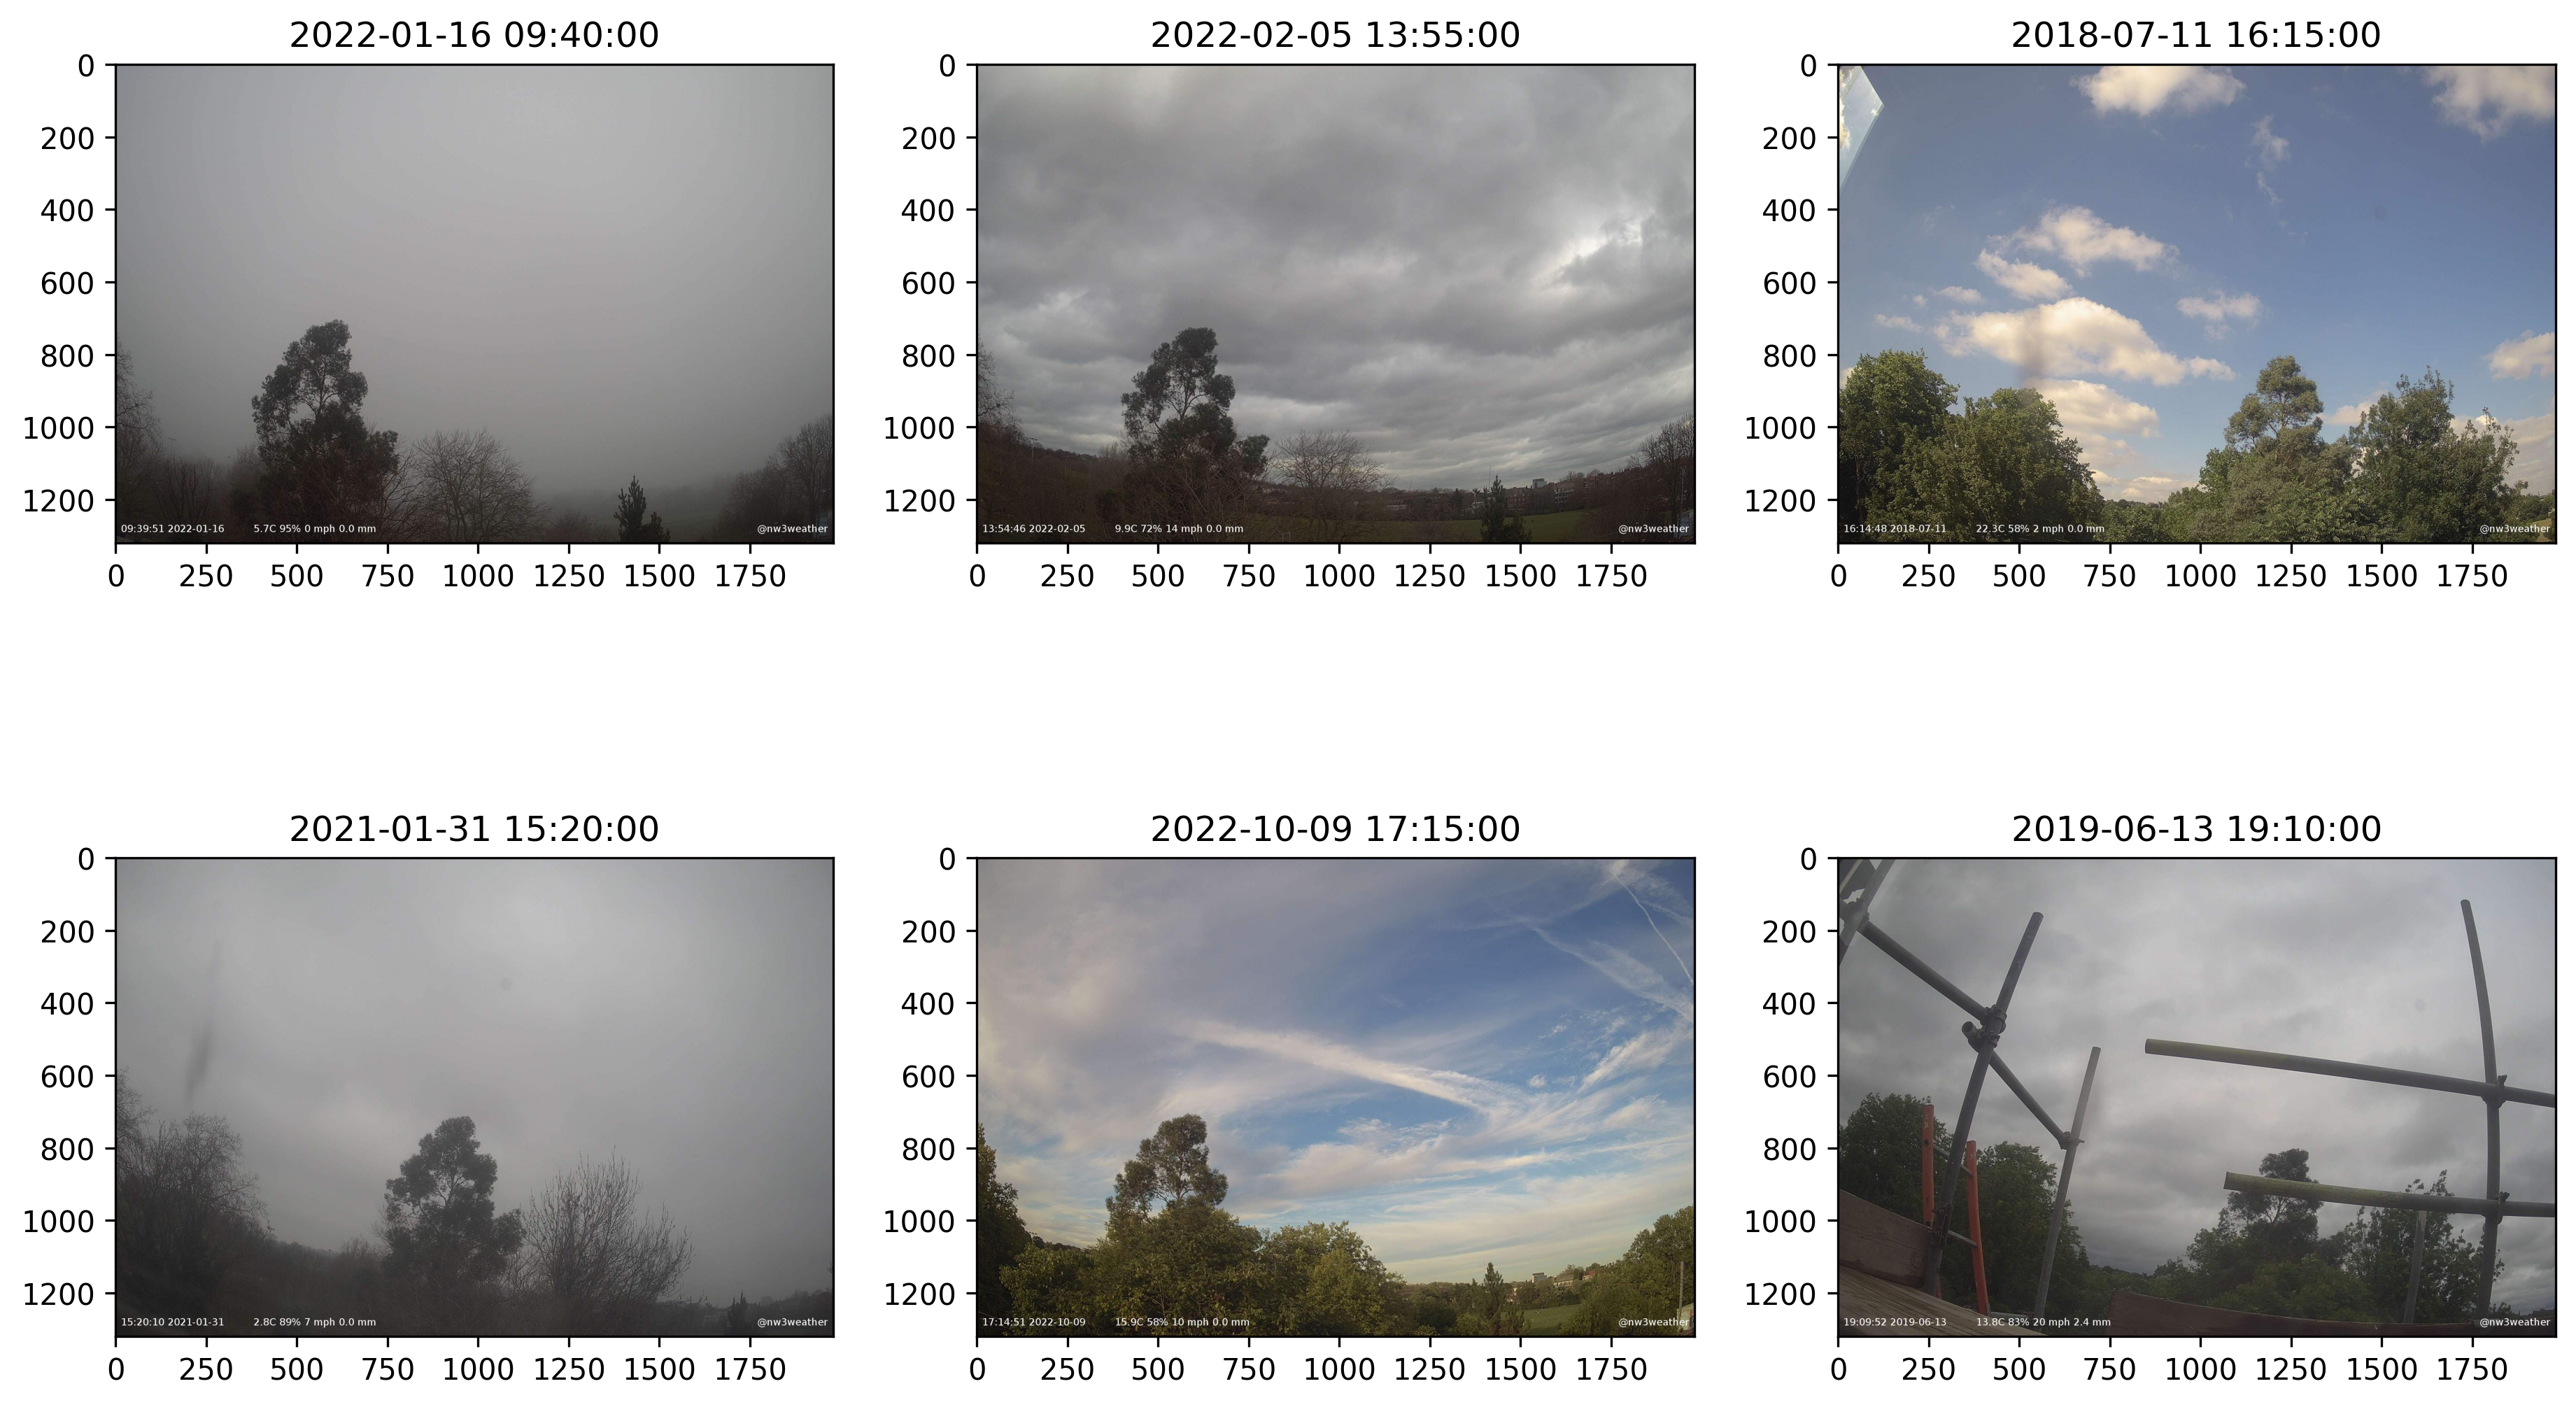

In [22]:
plt.figure(figsize=(15, 9), dpi=300)
plt.subplot(2,3,1)
plt.imshow(plt.imread(tmp.iloc[0,-1]))
plt.title(tmp.iloc[0,2])
plt.subplot(2,3,2)
plt.imshow(plt.imread(tmp.iloc[1,-1]))
plt.title(tmp.iloc[1,2])
plt.subplot(2,3,3)
plt.imshow(plt.imread(tmp.iloc[2,-1]))
plt.title(tmp.iloc[2,2])
plt.subplot(2,3,4)
plt.imshow(plt.imread(tmp.iloc[3,-1]))
plt.title(tmp.iloc[3,2])
plt.subplot(2,3,5)
plt.imshow(plt.imread(tmp.iloc[4,-1]))
plt.title(tmp.iloc[4,2])
plt.subplot(2,3,6)
plt.imshow(plt.imread(tmp.iloc[5,-1]))
plt.title(tmp.iloc[5,2])

plt.show()

In [49]:
tmp

azimuth  altitude            datetime  \
119453  0.108538  0.632680 2021-03-15 13:30:00   
47741   1.322724  0.675052 2019-07-14 17:45:00   
44343  -1.159446  0.812544 2019-06-25 11:10:00   
113267 -0.524558  0.195840 2021-01-09 11:00:00   
186493 -2.082523  0.018466 2022-07-30 06:35:00   
22732   0.338069  0.256322 2019-01-12 14:30:00   

                                                      URL  \
119453  http://nw3weather.co.uk/camchive/hik/2021/03/1...   
47741   http://nw3weather.co.uk/camchive/hik/2019/07/1...   
44343   http://nw3weather.co.uk/camchive/hik/2019/06/2...   
113267  http://nw3weather.co.uk/camchive/hik/2021/01/0...   
186493  http://nw3weather.co.uk/camchive/hik/2022/07/3...   
22732   http://nw3weather.co.uk/camchive/hik/2019/01/1...   

                       foto_filepath  
119453  ./SkyCam/2021_03_15_1330.jpg  
47741   ./SkyCam/2019_07_14_1745.jpg  
44343   ./SkyCam/2019_06_25_1110.jpg  
113267  ./SkyCam/2021_01_09_1100.jpg  
186493  ./SkyCam/2022_07_30_0635.jpg  
22732   ./SkyCam/2019_01_12_1430.jpg

In [23]:
y=plt.imread(tmp.iloc[5,-1])

In [24]:
y.shape

(1320, 1980, 3)